In [ ]:
import numpy as np
# import torch
import math
# from torch import nn
# import torch.nn.functional as F
# from torch import distributions as pyd

from utils import util, buffer
from utils.util import unpack_batch
# import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
# from sklearn.decomposition import NMF
from utils import util, buffer
import pickle
# import h5py

import os
from sklearn.decomposition import PCA
from visualize import plot_gif


ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No su

In [4]:
fit_soft_info = pickle.load(open('./keymoseq/fit_soft_info.pkl', 'rb'))
print(fit_soft_info.keys())
average_state_ar, average_action_ar, initial_state, initial_task, u_matrix = \
    fit_soft_info['average_state_ar'], fit_soft_info['average_action_ar'], \
    fit_soft_info['initial_state'], fit_soft_info['initial_task'], \
    fit_soft_info['u_matrix']
print(average_state_ar.shape, average_action_ar.shape, initial_state.shape, initial_task.shape, u_matrix.shape)

dict_keys(['average_state_ar', 'average_action_ar', 'initial_state', 'initial_task', 'u_matrix'])
(64, 16) (64, 16) (250, 16) (250, 1) (250, 64)


In [3]:
state_seq = initial_state[34:39].reshape(5,8,2)
state_seq_centered = state_seq - np.mean(state_seq, axis=(0,1), keepdims=True)
print(state_seq_centered[:,0])

[[-0.08499999  0.17850012]
 [-0.08499999  0.17850012]
 [-0.08499999  0.17850012]
 [-0.08499999  0.17850012]
 [-0.07499999  0.17850012]]


In [17]:
from plot import plot_gif_onefig
w = 2
x_vlines = [43,71,85,113,167, 171]
for center in x_vlines:
    state_seq = initial_state.copy()[center-w:center+w+1]
    plot_gif_onefig(state_seq, f'./keymoseq/skill_t_{center}.pdf', dpi=400)
    plt.close()

(5, 16)
state_seqs_to_plot: (5, 8, 2)
[[ 0.13736862 -0.50263137]
 [ 0.14736861 -0.49263138]
 [ 0.14736861 -0.49263138]
 [ 0.14736861 -0.49263138]
 [ 0.15736862 -0.49263138]]
./keymoseq/skill_t_43.pdf
(5, 16)
state_seqs_to_plot: (5, 8, 2)
[[ 0.2773686  -0.5926314 ]
 [ 0.2673686  -0.6026314 ]
 [ 0.25736862 -0.6226314 ]
 [ 0.23736861 -0.63263136]
 [ 0.22736862 -0.6426314 ]]
./keymoseq/skill_t_71.pdf
(5, 16)
state_seqs_to_plot: (5, 8, 2)
[[ 0.21736862 -0.69263136]
 [ 0.21736862 -0.69263136]
 [ 0.21736862 -0.69263136]
 [ 0.21736862 -0.69263136]
 [ 0.21736862 -0.69263136]]
./keymoseq/skill_t_85.pdf
(5, 16)
state_seqs_to_plot: (5, 8, 2)
[[ 0.19736862 -0.70263135]
 [ 0.19736862 -0.70263135]
 [ 0.18736862 -0.70263135]
 [ 0.17736861 -0.70263135]
 [ 0.17736861 -0.70263135]]
./keymoseq/skill_t_113.pdf
(5, 16)
state_seqs_to_plot: (5, 8, 2)
[[-0.06263138 -0.56263137]
 [-0.06263138 -0.56263137]
 [-0.06263138 -0.56263137]
 [-0.06263138 -0.56263137]
 [-0.06263138 -0.56263137]]
./keymoseq/skill_t_167.pd

In [7]:
u_matrix_idx = np.argsort(u_matrix, axis=1)[:,::-1]
unique_n, count = show_idx = np.unique(u_matrix_idx[:,:2], return_counts=True)
print(show_idx)
filtered_n = unique_n[count>10]
print(filtered_n)

(array([ 0,  2,  4,  5,  6,  8,  9, 10, 11, 12, 15, 16, 17, 19, 20, 21, 22,
       23, 24, 25, 26, 31, 32, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46,
       47, 48, 50, 52, 53, 54, 55, 56, 57, 58, 59, 61, 63]), array([ 5, 11,  7,  8, 62,  4,  1,  1, 12,  2,  1,  5, 10,  3,  5,  4,  9,
       45,  5,  2,  1,  1,  3,  3,  1,  4,  6,  8, 12,  1, 24,  1, 30,  6,
        7,  2,  4,  1,  1,  3,  1,  2, 60, 80, 33,  2,  1]))
[ 2  6 11 23 40 43 45 57 58 59]


In [14]:
from plot import get_edges
def show_sa_all(axs, state_all, action_all, skill_all, skill_cmap):
  # state_all: [n_sample, state_dim]
  # action_all: [n_sample, action_dim]
  edges, state_name, n_dim = get_edges(state_all.shape[-1])
  n_bodyparts = len(state_name)
  n_sample = state_all.shape[0]
  state_seqs_to_plot = state_all.reshape(-1, n_bodyparts, 2)
  action_seqs_to_plot = action_all.reshape(-1, n_bodyparts, 2)
  cmap = plt.cm.get_cmap('summer')
  keypoint_colors = cmap(np.linspace(0, 1, len(state_name)))
  axmin = -0.3
  axmax = 0.3
  aymin = -0.3
  aymax = 0.3
  xym = [axmin, axmax, aymin, aymax]
  skill_colors = [skill_cmap.colors[i%len(skill_cmap.colors)] for i in range(n_sample)]
  for i in range(n_sample):
    show_sa_single(axs[i], skill_all[i], state_seqs_to_plot[i], action_seqs_to_plot[i], 
                   edges, keypoint_colors, skill_colors[i], axspine_width=10, xym=xym)


def show_sa_single(ax, syllable, state, action, edges, keypoint_colors, syllable_color, axspine_width=10, xym=[-0.3,0.3,-0.3,0.3]):
  show_s(ax, state, edges, keypoint_colors)
  show_a(ax, state, action)
  ax.set_title(f'{syllable}', fontsize=20)
  ax.set_xlim(xym[0], xym[1])
  ax.set_ylim(xym[2], xym[3])
  ax.set_xticks([])
  ax.set_yticks([])
  set_ax_color_width(ax, syllable_color, axspine_width)

def show_s(ax, state_seq, edges, keypoint_colors):
  # state_seq: [n_bodyparts, 2]
  '''
      for p1, p2 in edges:
        axis.plot(
            *state_seqs_to_plot[i, (p1, p2)].T,
            color=keypoint_colors[p1],
            linewidth=5.0,zorder=i*4)
      for p1, p2 in edges:
        axis.plot(
            *state_seqs_to_plot[i, (p1, p2)].T,
            color='black',
            linewidth=5.0*0.9,zorder=i*4+1)
      axis.scatter(
          *state_seqs_to_plot[i].T,
          c=keypoint_colors,
          edgecolors='black',
          s=100,zorder=i*4+2)'''
  for p1, p2 in edges:
    ax.plot(
        *state_seq[(p1, p2), :].T,
        color=keypoint_colors[p1],
        linewidth=5.0, zorder=0)
  for p1, p2 in edges:
    ax.plot(
        *state_seq[(p1, p2), :].T,
        color='black',
        linewidth=5.0*0.9, zorder=1)
  ax.scatter(
      *state_seq.T,
      c=keypoint_colors,
      edgecolors='black',
      s=100, zorder=2)
def show_a(ax, state_seq, action_seq):
  n_bodyparts = state_seq.shape[0]
  for k in range(n_bodyparts):
    ax.quiver(state_seq[k, 0], state_seq[k, 1], 
              action_seq[k, 0], action_seq[k, 1], 
              angles='xy', scale_units='xy', scale=0.07, color='r',
              width=0.01, headwidth=3, headlength=5, zorder=3)
def set_ax_color_width(ax, color, linewidth):
  # ax.axis('off')
  for spine in ax.spines.values():
    spine.set_color(color)
    spine.set_linewidth(linewidth)

In [16]:
filter_ave_state_ar = average_state_ar[filtered_n]
filter_ave_action_ar = average_action_ar[filtered_n]
fig, ax = plt.subplots(2,5, figsize=(20, 8))
ax = ax.flatten()
show_sa_all(ax, filter_ave_state_ar, filter_ave_action_ar, filtered_n, plt.cm.get_cmap('tab10'))
plt.savefig('./keymoseq/skill_all.pdf', dpi=400)
plt.close()

0.13894151


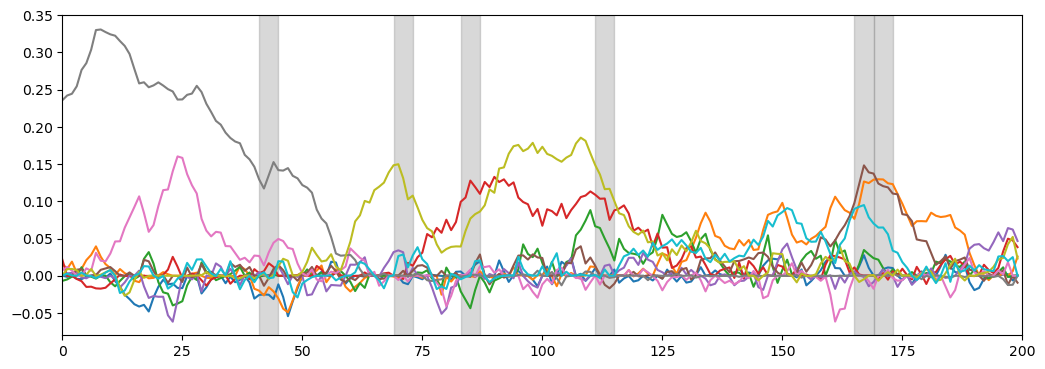

In [18]:
skill_cmap = plt.cm.get_cmap('tab10')      
u_matrix_high_freq = u_matrix[:200, filtered_n]
fig, ax = plt.subplots(figsize=(12,4))
for j in range(u_matrix_high_freq.shape[1]):
    ax.plot(u_matrix_high_freq[:,j], label=f'{j}', color=skill_cmap.colors[j%len(skill_cmap.colors)])
ax.set_xlim(0, 200)
ax.set_ylim(-0.08, 0.35)
x_vlines = [43,71,85,113,167, 171]
for x_vline in x_vlines:
    # ax.axvline(x=x_vline, color='gray', linestyle='--', linewidth=1)
    ax.fill_betweenx(y=[-0.08, 0.35], x1=x_vline-2, x2=x_vline+2, color='gray', alpha=0.3)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig('./keymoseq/u_matrix_high_freq.pdf', dpi=400)
print(u_matrix[168,43])

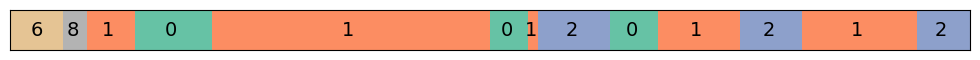

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12,0.5))
task_seq = initial_task[:200].reshape(-1)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
ax.imshow(task_seq.reshape(1,-1), cmap='Set2', aspect='auto', interpolation='nearest',
          extent = (0, task_seq.shape[0], 0, 1))
# ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
task_transition = np.where(np.diff(task_seq))[0]
task_unique_order = task_seq[task_transition+1]
task_unique_order = np.concatenate(([task_seq[0]], task_unique_order))
task_transition = np.concatenate(([0], task_transition, [task_seq.shape[0]-1]))
for j in range(len(task_unique_order)):
    xcoord = (task_transition[j] + task_transition[j+1]) / 2 + 0.5
    ax.annotate(f'{int(task_unique_order[j])}', xy=(xcoord, 0.5),
                    fontsize=14, ha='center', va='center')
plt.savefig('./keymoseq/task_seq.pdf', dpi=400)

(5, 16)
./keymoseq/skill_t_36.png
(5, 16)
./keymoseq/skill_t_71.png
(5, 16)
./keymoseq/skill_t_85.png
(5, 16)
./keymoseq/skill_t_112.png
(5, 16)
./keymoseq/skill_t_167.png


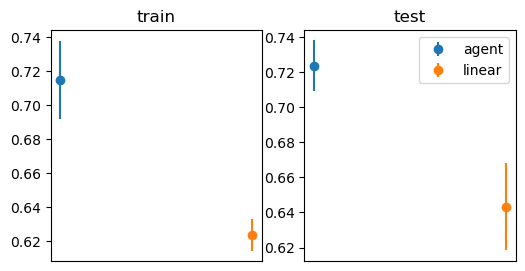

train_auc_agent: 0.7148129024166668 train_auc_linear: 0.6237434309166666 t: 3.0809131534241736 p: 0.02744114459376091
test_auc_agent: 0.723634047 test_auc_linear: 0.6433330769166666 t: 2.256040426965717 p: 0.07371656876956938


In [20]:
from scipy.stats import ttest_rel
auc_all = open('./kms/auc_average_1_grw.txt', 'r')
auc_all = auc_all.readlines()
train_auc_agent = []
train_auc_linear = []
test_auc_agent = []
test_auc_linear = []
for i in range(len(auc_all)):
    auc_all[i] = auc_all[i].split()
    # print(auc_all[i])
    if 'train' in auc_all[i][0]:
        train_auc_agent.append(float(auc_all[i][1]))
        # print(auc_all[i][1])
        train_auc_linear.append(float(auc_all[i][2]))
        # print(auc_all[i][2])
    
    if 'test' in auc_all[i][0]:
        test_auc_agent.append(float(auc_all[i][1]))
        # print(auc_all[i][1])
        test_auc_linear.append(float(auc_all[i][2]))
        # print(auc_all[i][2])
# print('train_auc_agent:', train_auc_agent)
# print('train_auc_linear:', train_auc_linear)
train_auc_agent = np.array(train_auc_agent)
train_auc_linear = np.array(train_auc_linear)
test_auc_agent = np.array(test_auc_agent)
test_auc_linear = np.array(test_auc_linear)
fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].errorbar(0, train_auc_agent.mean(), yerr=train_auc_agent.std()/math.sqrt(len(train_auc_agent)-1), fmt='o', label='agent') 
ax[0].errorbar(1, train_auc_linear.mean(), yerr=train_auc_linear.std()/math.sqrt(len(train_auc_linear)-1), fmt='o', label='linear')
ax[1].errorbar(2, test_auc_agent.mean(), yerr=test_auc_agent.std()/math.sqrt(len(test_auc_agent)-1), fmt='o', label='agent')
ax[1].errorbar(3, test_auc_linear.mean(), yerr=test_auc_linear.std()/ math.sqrt(len(test_auc_linear)-1), fmt='o', label='linear')
ax[0].set_title('train')
ax[1].set_title('test')
ax[0].set_xticks([])
ax[1].set_xticks([])
plt.legend()
plt.savefig('./kms/auc_av_grw_10.png')
plt.show()
t1, p1 = ttest_rel(train_auc_agent, train_auc_linear)
t2, p2 = ttest_rel(test_auc_agent, test_auc_linear)
print('train_auc_agent:', train_auc_agent.mean(), 'train_auc_linear:', train_auc_linear.mean(), 't:', t1, 'p:', p1)
print('test_auc_agent:', test_auc_agent.mean(), 'test_auc_linear:', test_auc_linear.mean(), 't:', t2, 'p:', p2)

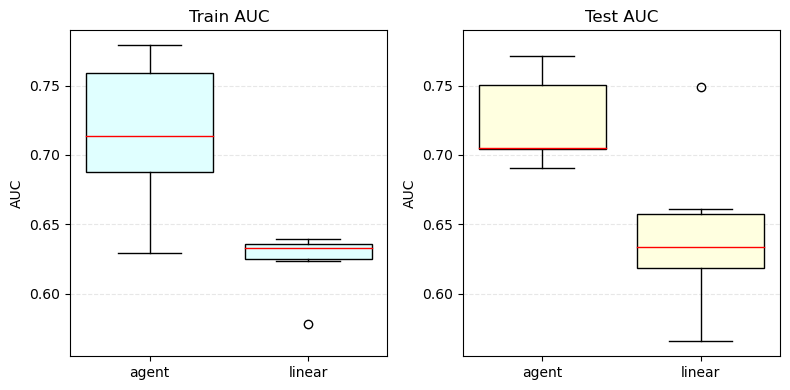

In [28]:

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# 训练集的箱线图
axes[0].boxplot(
    [train_auc_agent, train_auc_linear],
    labels=['agent', 'linear'],
    widths=0.8,                    # ← 这里
    patch_artist=True,
    boxprops={'facecolor':'lightcyan','edgecolor':'black'},
    medianprops={'color':'red'}
)
axes[0].set_title('Train AUC')

# 测试集箱线图：同样调整
axes[1].boxplot(
    [test_auc_agent, test_auc_linear],
    labels=['agent', 'linear'],
    widths=0.8,                    # ← 这里
    patch_artist=True,
    boxprops={'facecolor':'lightyellow','edgecolor':'black'},
    medianprops={'color':'red'}
)
axes[1].set_title('Test AUC')

for ax in axes:
    ax.set_ylabel('AUC')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.tick_params(axis='y', labelleft=True)

plt.tight_layout()
plt.savefig('./keymoseq/auc_boxplot.pdf', dpi=300)
plt.show()

In [ ]:
state_dim = 16
action_dim = 16
n_task = 78
feature_dim = 512
test_buffer_path = './kms/replay_buffer_all_normalized.pth'
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
replay_buffer.load_state_dict(torch.load(test_buffer_path))
uvec = np.load('./kms/u_vec_16to512.npy')
sample_len = 250
for i in range(10):
    sample_idx = np.random.randint(0, replay_buffer.size)+np.arange(sample_len)
    u_matrix = uvec[sample_idx]
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for j in range(sample_len):


    

In [2]:
patha = './figure/kms/spedersac/A_f16_task78_ctrl_critic_nohidden/0/pair_gif_and_u.gif'
from plot import convert_gif_to_mp4
convert_gif_to_mp4(patha)

Moviepy - Building video ./figure/kms/spedersac/A_f16_task78_ctrl_critic_nohidden/0/pair_gif_and_u.mp4.
Moviepy - Writing video ./figure/kms/spedersac/A_f16_task78_ctrl_critic_nohidden/0/pair_gif_and_u.mp4



Moviepy - Done !
Moviepy - video ready ./figure/kms/spedersac/A_f16_task78_ctrl_critic_nohidden/0/pair_gif_and_u.mp4


In [2]:
a = np.arange(5)
print(np.var(a, ddof=1))

2.5


In [3]:
from utils.util import unpack_batch
from plot import plot_gif_onefig
state_dim = 16
action_dim = 16
n_task = 78
test_buffer_path = './kms/test_data_all.pth'
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
replay_buffer.load_state_dict(torch.load(test_buffer_path))
# print(np.where(np.isclose(replay_buffer.action,0),1,0).mean())
# all_idxs = np.where(replay_buffer.task == 11)[0]
sample_len = 30
start_idx = 68290
sample_idx = start_idx + np.arange(sample_len)
state, action, next_state, reward, done, task, next_task = unpack_batch(replay_buffer.take(sample_idx))
plot_gif_onefig(state.detach().cpu().numpy(), f'./figure/kms/rollout_{start_idx}.png')
# plot_gif(state.detach().cpu().numpy(), f'./figure/kms/rollout_{start_idx}.gif', task.detach().cpu().numpy())

(30, 16)
ymin: () ymax: ()
keypoint_colors: [[0.267004 0.004874 0.329415 1.      ]
 [0.275191 0.194905 0.496005 1.      ]
 [0.212395 0.359683 0.55171  1.      ]
 [0.153364 0.497    0.557724 1.      ]
 [0.122312 0.633153 0.530398 1.      ]
 [0.288921 0.758394 0.428426 1.      ]
 [0.626579 0.854645 0.223353 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]
keypoint_colors: [[0.267004 0.004874 0.329415 1.      ]
 [0.275191 0.194905 0.496005 1.      ]
 [0.212395 0.359683 0.55171  1.      ]
 [0.153364 0.497    0.557724 1.      ]
 [0.122312 0.633153 0.530398 1.      ]
 [0.288921 0.758394 0.428426 1.      ]
 [0.626579 0.854645 0.223353 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]
keypoint_colors: [[0.267004 0.004874 0.329415 1.      ]
 [0.275191 0.194905 0.496005 1.      ]
 [0.212395 0.359683 0.55171  1.      ]
 [0.153364 0.497    0.557724 1.      ]
 [0.122312 0.633153 0.530398 1.      ]
 [0.288921 0.758394 0.428426 1.      ]
 [0.626579 0.854645 0.223353 1.      ]
 [0.993248 0.906157 0.1

In [15]:
  # state_seqs_all: [syllable, state_dim]
  # action_seqs_all: [syllable, action_dim]
from visualize import get_edges, unpack_batch
def plot_sa(state_seq, action_seq):
    edges, state_name, n_dim = get_edges(state_seq.shape[-1])
    fig, axis = plt.subplots(3, 4, figsize=(20, 15))
    n_bodyparts = len(state_name)
    n_sample = state_seq.shape[0]

    state_to_plot = state_seq.reshape(n_sample, -1, 2)
    state_to_plot -= state_to_plot.mean(axis=1, keepdims=True)
    _, eigenval, vhs = np.linalg.svd(state_to_plot)
    head_idx = state_name.index('head')
    n_bodyparts = len(state_name)
    pc1 = vhs[:,0,:] # [batch, 2, 2]
    head_vector = state_to_plot[:, head_idx, :]
    flip_sign1 = np.where(np.sum(head_vector*pc1, axis=-1, keepdims=True) < 0, -1, 1)
    leftear_index = state_name.index('left ear')
    pc2 = vhs[:,1,:]
    leftear_vector = state_to_plot[:, leftear_index, :]
    flip_sign2 = np.where(np.sum(leftear_vector*pc2, axis=-1, keepdims=True) < 0, -1, 1)
    pc1 = pc1 * flip_sign1
    pc2 = pc2 * flip_sign2
    vs_calib = np.stack([pc1, pc2], axis=-1)
    assert vs_calib.shape == (n_sample, 2, 2)
    scale_factor = eigenval[:,0].reshape(n_sample, 1, 1)
    rotating_s = np.matmul(state_to_plot, vs_calib)
    rotating_a = np.matmul(action_seq.reshape(n_sample, -1, 2), vs_calib)
    # s_all = rotating_s.reshape(n_sample, agent.state_dim)
    # a_all = rotating_a.reshape(n_sample, agent.action_dim)

    state_seqs_to_plot = rotating_s
    action_seqs_to_plot = rotating_a
    cmap = plt.cm.get_cmap('viridis')
    keypoint_colors = cmap(np.linspace(0, 1, len(state_name)))
    axmin = -0.3
    axmax = 0.3
    aymin = -0.3
    aymax = 0.3
    for j in range(n_sample):
        for p1, p2 in edges:
            axis[j//4, j%4].plot(
                *state_seqs_to_plot[j, (p1, p2)].T,
                color=keypoint_colors[p1],
                linewidth=5.0, zorder=0)
        axis[j//4, j%4].scatter(
            *state_seqs_to_plot[j].T,
            c=keypoint_colors,
            s=100, zorder=0)
        axis[j//4, j%4].set_title(f'{j}', fontsize=30)
        axis[j//4, j%4].axis('off')
        axis[j//4, j%4].set_xlim(axmin, axmax)
        axis[j//4, j%4].set_ylim(aymin, aymax)
        for k in range(n_bodyparts):
            axis[j//4, j%4].quiver(state_seqs_to_plot[j, k, 0], state_seqs_to_plot[j, k, 1], 
                                action_seqs_to_plot[j, k, 0], action_seqs_to_plot[j, k, 1], 
                                angles='xy', scale_units='xy', scale=0.2, color='r', zorder=1)
    plt.tight_layout()
    plt.show()
    return fig, axis
def sample_and_plot(dataset, n_sample):
    all_idx = np.where(dataset.task==2)[0]
    # sample_idx = all_idx[np.random.randint(0, len(all_idx), n_sample)]
    sample_idx = np.array([6514, 5467,  4947,  5428,  7586, 13119, 11209, 12561, 2036, 10781])
    # sample_idx = 17387  #Left
    # sample_idx = 67040  #Right
    # sample_idx = np.array([17387, 67040])
    print(f'sample_idx: {sample_idx}')
    state, action, next_state, reward, done, task, next_task = unpack_batch(dataset.take(sample_idx))
    print('action:', action)
    plot_sa(state.numpy(), action.numpy())

sample_idx: [ 6514  5467  4947  5428  7586 13119 11209 12561  2036 10781]
action: tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.0100, -0.0100, -0.0100, -0.0100,  0.0000,  0.0000, -0.0100],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.0100,  0.0100, -0.0100,  0.0000, -0.0100,  0.0100,  0.0000],
        [ 0.0000,  0.0100,  0.0100,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0100,  0.0000,  0.0100,  0.0000,  0.0100,  0.0000,  0.0000,  0.0000],
        [-0.0100,  0.0000, -0.0100,  0.0000, -0.0100, -0.0100, -0.0100,  0.0000,
         -0.0100,  0.0000, -0.0200,  0.0000, -0.0100, -0.0100, -0.0200,  0.0000],
        [ 0.0000,  0.0100,  0.0000,  0.0000,  0.0000, -0.0100,  0.0000, -0.0100,
          0.0100, -0.0100,  0.0000, -0.0100,  0.0000, -0.0100,  0.0000,  0.0000],
        [ 0.0000,  0.0100, -0.0100,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0

/tmp/ipykernel_15230/3208959166.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


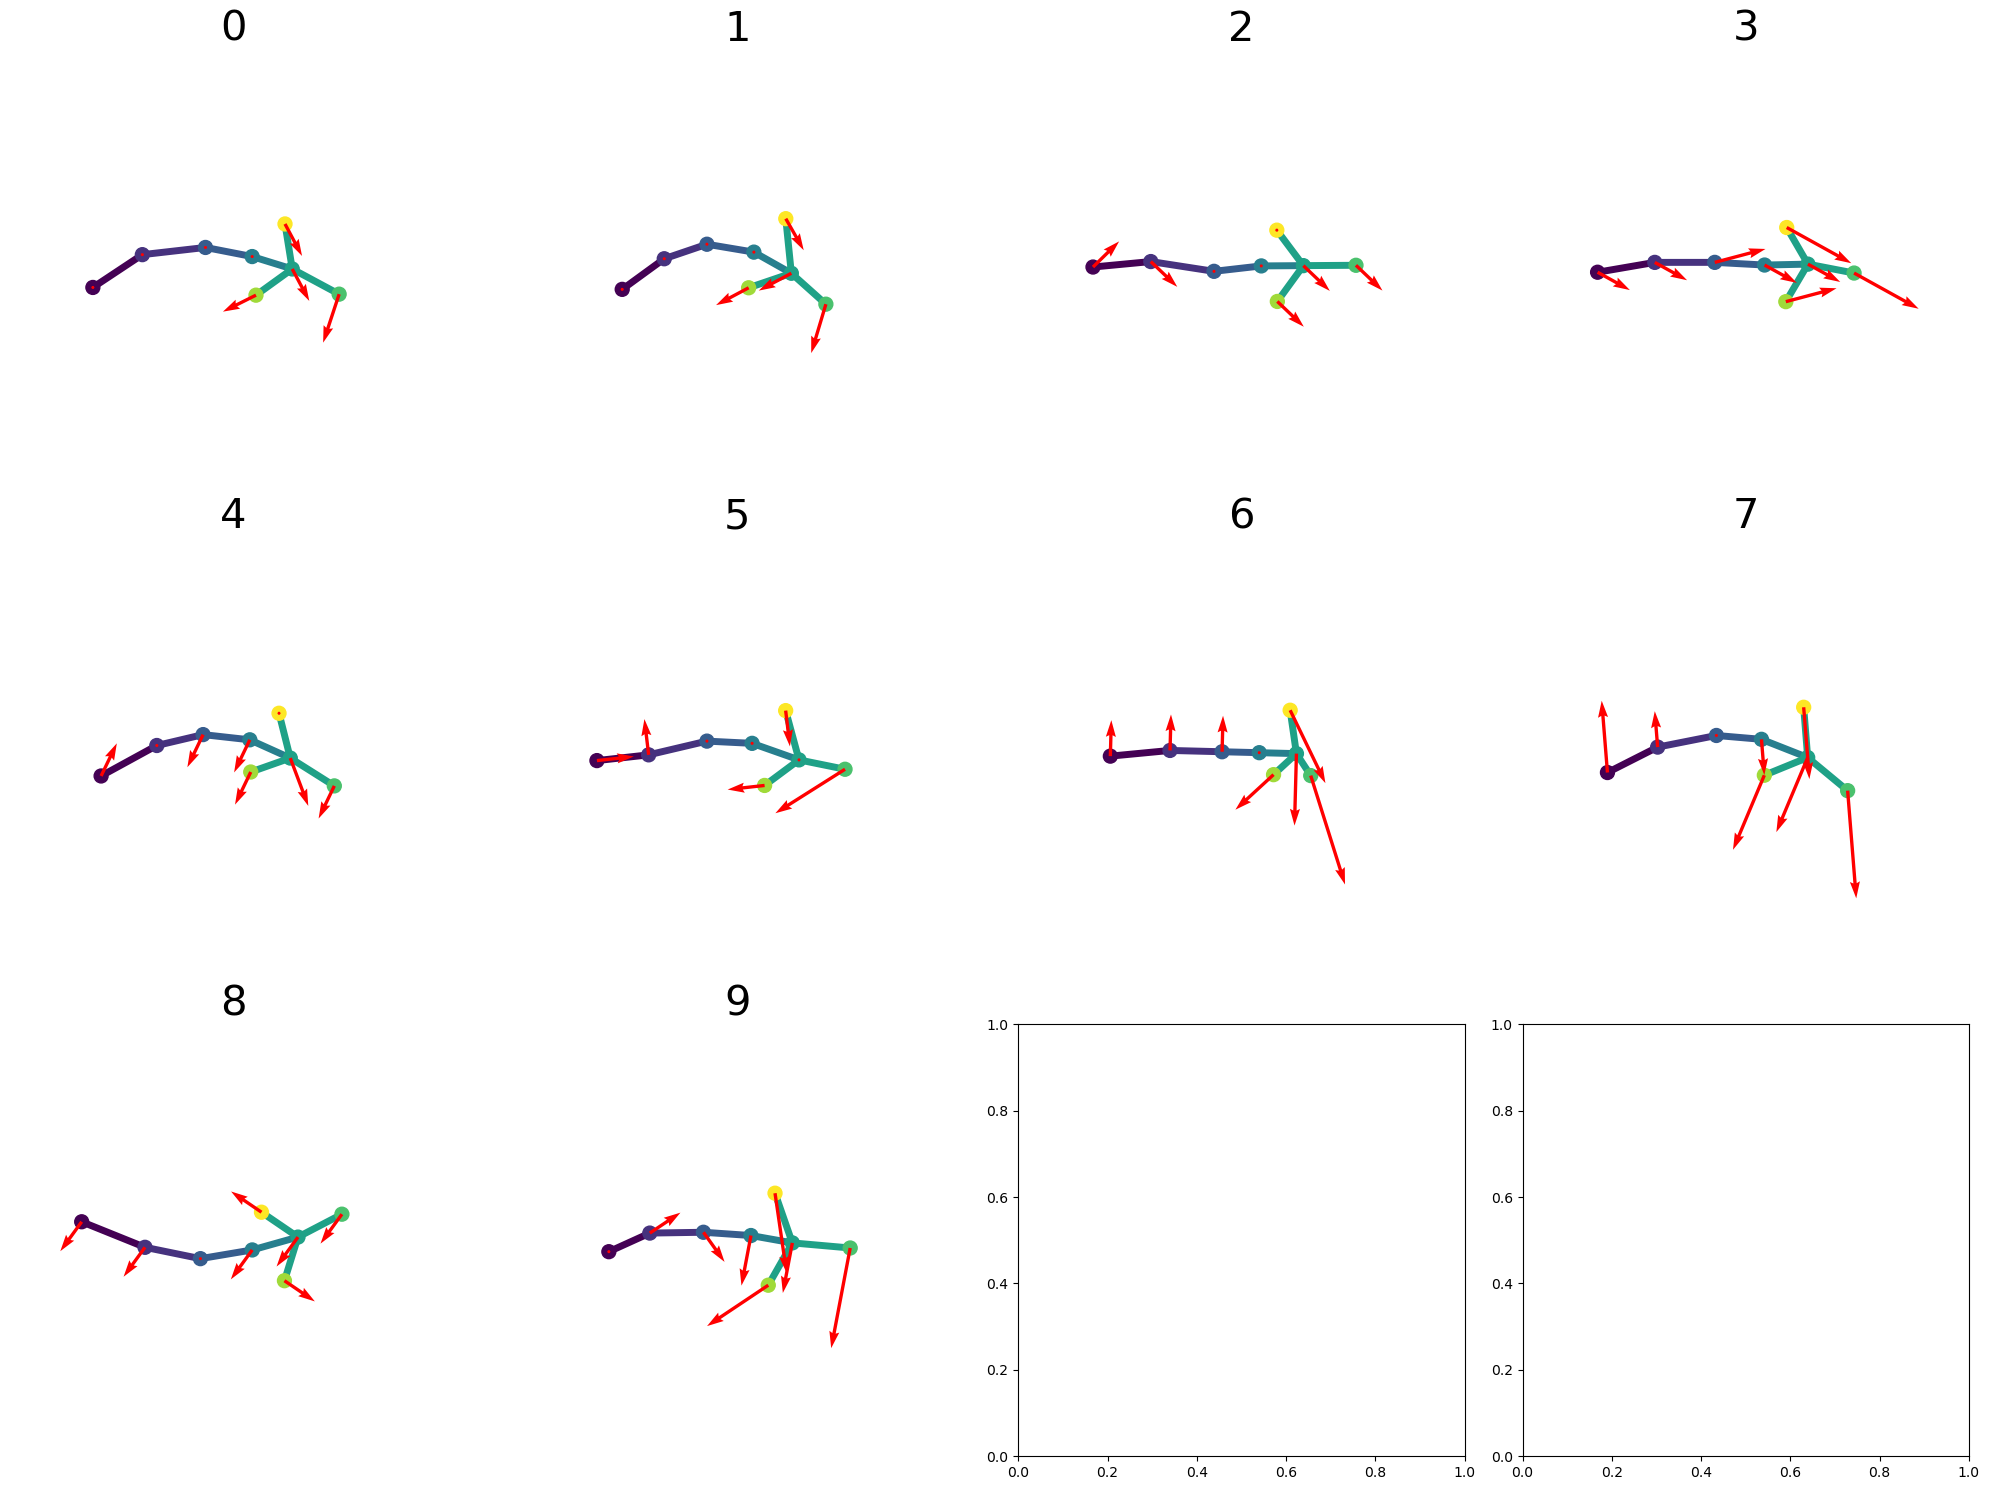

In [16]:
state_dim = 16
action_dim = 16
n_task = 10
device = torch.device('cpu')
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 1000000, device)
replay_buffer_path = f'./kms/test_data_24.pth'
replay_buffer.load_state_dict(torch.load(replay_buffer_path))
assert np.isclose(replay_buffer.state[0:5]+replay_buffer.action[0:5], replay_buffer.next_state[0:5]).all()
sample_and_plot(replay_buffer, 10)
idx2 = np.array([ 7591,  9753,  7507, 12315,  1790,  8621,  4739,  2836,  9721,  3280])

In [ ]:
a = np.load('model/kms/spedersac/S_f128_datasets200a200_CD_norm1_ctrl/0/args_kwargs.npy', allow_pickle=True)
print(a)

Filter syllable 2 & 4 based on rotating direction

In [ ]:
# from visualize import plot_gif
from visualize import is_clockwise
state_dim = 16
action_dim = 16
n_task = 10
test_buffer_path = './kms/replay_buffer_mildnormalized_state200_action200.pth'
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
test_buffer.load_state_dict(torch.load(test_buffer_path))
replay_buffer_filter = buffer.ReplayBuffer(state_dim, action_dim, 100000)
for i in [2]:
    all_idxs = np.where(test_buffer.task==i)[0]
    transition = np.where(np.diff(all_idxs)>1)[0]
    # print(transition)
    transition_list = np.concatenate(([0], transition))
    print(len(transition_list))
    for j in range(len(transition_list)-1):
        start = all_idxs[transition_list[j]+1]
        end = all_idxs[transition_list[j+1]]
        if start >= end-1:
            continue
        state_seqs = test_buffer.state[start:end]
        clockwise, pc_to_plot = is_clockwise(state_seqs)
        if (i==2 and clockwise):
            for k in range(start, end):
                if k == end-1:
                    done = 1
                else:
                    done = 0
                replay_buffer_filter.add(test_buffer.state[k], test_buffer.action[k], test_buffer.next_state[k], 
                                         test_buffer.reward[k], done, test_buffer.task[k], test_buffer.next_task[k])
print(replay_buffer_filter.size)
torch.save(replay_buffer_filter.state_dict(), './kms/replay_buffer_mildnormalized_state200_action200_filter2.pth')

In [ ]:
from visualize import get_edges
def plot_figure_PC(state, save_path):
  # state: [state_dim, ]
  edges, state_name, n_dim = get_edges(state.shape[-1])
  fig, axis = plt.subplots(1, 1, figsize=(5, 6))
  state_to_plot = state.reshape(-1, 2)
  state_to_plot -= state_to_plot.mean(axis=0)
  _, _, vhs = np.linalg.svd(state_to_plot)
  pc_to_plot = vhs[0]
  cmap = plt.cm.get_cmap('viridis')
  keypoint_colors = cmap(np.linspace(0, 1, len(state_name)))
  xmin = -0.2
  xmax = 0.2
  ymin = -0.2
  ymax = 0.2
  # xmin = min(state_to_plot[:, 0].min(), pc_to_plot[0])
  # xmax = max(state_to_plot[:, 0].max(), pc_to_plot[0])
  # ymin = min(state_to_plot[:, 1].min(), pc_to_plot[1])
  # ymax = max(state_to_plot[:, 1].max(), pc_to_plot[1])
  axis.set_xlim(xmin, xmax)
  axis.set_ylim(ymin, ymax)
  for p1, p2 in edges:
    axis.plot(
        *state_to_plot[(p1, p2),:].T,
        color=keypoint_colors[p1],
        linewidth=5.0)
  axis.scatter(
      *state_to_plot.T,
      c=keypoint_colors,
      s=100)
  axis.quiver(0, 0, pc_to_plot[0], pc_to_plot[1], angles='xy', scale_units='xy', scale=10, color='r')
  if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))
  plt.savefig(save_path)

state_dim = 16
action_dim = 16
n_task = 10
test_buffer_path = './kms/test_data_continuous_a200.pth'
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
test_buffer.load_state_dict(torch.load(test_buffer_path))
state = test_buffer.state[90]
save_path = './figure/kms/pc.png'
plot_figure_PC(state, save_path)

Pick out gif from dataset

In [ ]:
from visualize import plot_gif
state_dim = 16
action_dim = 16
n_task = 10
test_buffer_path = './kms/replay_buffer_all_normalized.pth'
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
test_buffer.load_state_dict(torch.load(test_buffer_path))
for j in [2, 4]:
    all_idxs = np.where(test_buffer.task==j)[0]
    print(all_idxs)
    transition = np.where(np.diff(all_idxs)>1)[0]
    print(transition)
    transition_list = np.concatenate(([0], transition))
    print(transition_list)
    i=0
    while i<10:
        k = np.random.randint(0, len(all_idxs)-10)
        start = all_idxs[k]
        end = all_idxs[k]+10
        done_seqs = test_buffer.done[start:end]
        if np.sum(done_seqs) > 0:
            continue
        state_seqs = test_buffer.state[start:end]
        plot_gif(state_seqs, f'./figure/kms/task_gif/task_{j}/{i}.gif')
        i += 1
        

In [ ]:
from visualize import plot_gif
state_dim = 16
action_dim = 16
n_task = 10
test_buffer_path = './kms/replay_buffer_mildnormalized_state200_action200.pth'
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
test_buffer.load_state_dict(torch.load(test_buffer_path))

for j in range(n_task):
    all_idxs = np.where(test_buffer.task==j)[0]
    # print(all_idxs)
    transition = np.where(np.diff(all_idxs)>1)[0]
    # print(transition)
    transition_idx = all_idxs[transition]
    all_done = test_buffer.done[transition_idx]
    done_zero = np.where(all_done==0)[0]
    # print(transition_idx[done_zero])
    # original_idx = transition_idx[done_zero]
    # print(original_idx)
    # print(replay_buffer.state[original_idx])
    # print()
    # print(all_done.reshape(-1))
    # print(np.all(np.isclose(all_done, 1)))
    # continue
    transition_list = np.concatenate(([0], transition))
    print(transition_list)
    i=0
    while i<10:
        
        k = np.random.randint(0, len(transition_list)-1)
        start = all_idxs[transition_list[k]+1]
        end = all_idxs[transition_list[k+1]]
        print(start, end)
        if start == end:
            continue
        state_seqs = test_buffer.state[start:end]
        plot_gif(state_seqs, f'./figure/kms/task_gif/task_{j}/{i}.gif')
        i += 1
        
# state_seqs = replay_buffer.state[1172:1182]
# plot_gif(state_seqs, f'./figure/kms/task2_continuous.gif')

In [ ]:
state_dim = 16
action_dim = 16
n_task = 10
test_buffer_path = './kms/replay_buffer_mildnormalized_state200_action200.pth'
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
test_buffer.load_state_dict(torch.load(test_buffer_path))
print(test_buffer.task[1150:1165].reshape(-1))
print(test_buffer.done[1150:1165].reshape(-1))

In [ ]:
def check_multiple_step_rollout(lr, syllable, replay_buffer):
    syllable_idx = np.where(replay_buffer.task == syllable)[0]
    transition = np.where(np.diff(syllable_idx) != 1)[0]+1
    print(len(transition))
    state_seqs = [None] * (len(transition)-1)
    for i in range(len(transition)-1):
        # print(transition[i], transition[i+1])
        # print(syllable_idx[transition[i]:transition[i+1]-1])
        state_seqs[i] = replay_buffer.state[syllable_idx[transition[i]:transition[i+1]-1]]
        assert state_seqs[i].shape[-1] == 16
    all_error = np.zeros(len(transition)-1)
    for i in range(len(state_seqs)):
        imitation_state_seq = np.zeros_like(state_seqs[i])
        # print(state_seqs[i], transition[i], syllable_idx[transition[i]:transition[i+1]-1])
        imitation_state_seq[0] = state_seqs[i][0]
        for j in range(1, state_seqs[i].shape[0]):
            imitation_state_seq[j] = lr.predict(imitation_state_seq[j-1].reshape(1, -1)).reshape(-1)
        error = np.mean(np.abs(imitation_state_seq - state_seqs[i]))
        # print(i, error)
        all_error[i] = error
    # print('all:', all_error.mean())
    return all_error.mean()

Show the fitting result of linear model

In [ ]:
from sklearn.linear_model import LinearRegression
from visualize import plot_gif
lr = LinearRegression()
test_buffer_path = './kms/train_data.pth'
replay_buffer_state_dict = torch.load(test_buffer_path)
state_dim, action_dim = 16, 80
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, max_size=10000)
test_buffer.load_state_dict(replay_buffer_state_dict)
state = replay_buffer_state_dict['state']
action = replay_buffer_state_dict['action']
next_state = replay_buffer_state_dict['next_state']
print(state.shape, next_state.shape)
# sa_input = np.concatenate([state, action], axis=1)
# split train and test buffer
# train_buffer_size = int(0.8 * len(znormalized_state))
# print(train_buffer_size)
lr.fit(state, action)
test_buffer_path = './kms/test_data.pth'
test_buffer_state_dict = torch.load(test_buffer_path)
test_state = test_buffer_state_dict['state']
test_action = test_buffer_state_dict['action']
test_next_state = test_buffer_state_dict['next_state']
test_action_pred = lr.predict(test_state)
error = np.abs(test_action_pred - test_action)
print(error.shape)
error_mean = np.mean(error, axis=0)
print(error_mean, error_mean.mean())
torch.save(lr, './kms/linear_model_discrete.pth')


In [5]:
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
replay_buffer_path = './kms/replay_buffer_all_normalized.pth'
replay_buffer.load_state_dict(torch.load(replay_buffer_path))
n_syllable = 78
for syllable in range(n_syllable):
    lr = LinearRegression()
    idx = np.where(replay_buffer.task == syllable)[0]
    print(len(idx))

131108
59812
42725
47387
39871
48782
51433
23759
24973
18731
16190
9936
10839
14886
13244
20201
9627
2072
2720
10088
344
4630
2116
5316
12381
2465
3131
709
2452
279
1558
1389
3583
204
190
37
1031
486
112
26
21
14
305
47
344
124
874
73
63
179
250
104
10
18
20
41
50
42
20
106
13
10
23
15
5
11
10
4
6
6
5
214
11
15
6
7
9
3


syllable: 0
det: [-171.18425352]
syllable: 1
det: [-159.67933866]
syllable: 2
det: [-164.49249251]
syllable: 3
det: [-162.0867279]
syllable: 4
det: [-164.40011641]
syllable: 5
det: [-164.34920999]
syllable: 6
det: [-161.69262928]
syllable: 7
det: [-155.65013872]
syllable: 8
det: [-158.45776121]
syllable: 9
det: [-160.65977929]
syllable: 10
det: [-163.62199718]
syllable: 11
det: [-124.23292199]
syllable: 12
det: [-133.93078013]
syllable: 13
det: [-163.46273714]
syllable: 14
det: [-156.00122769]
syllable: 15
det: [-132.16245287]
syllable: 16
det: [-162.76828014]
syllable: 17
det: [-117.45645916]
syllable: 18
det: [-110.67055025]
syllable: 19
det: [-164.40377509]
syllable: 20
det: [-111.49453581]
syllable: 21
det: [-157.50072385]
syllable: 22
det: [-138.48520691]
syllable: 23
det: [-161.30532275]
syllable: 24
det: [-176.26390151]
syllable: 25
det: [-154.43464377]
syllable: 26
det: [-145.29266382]
syllable: 27
det: [-131.46962179]
syllable: 28
det: [-144.64479029]
syllable: 29
det: [-154.2

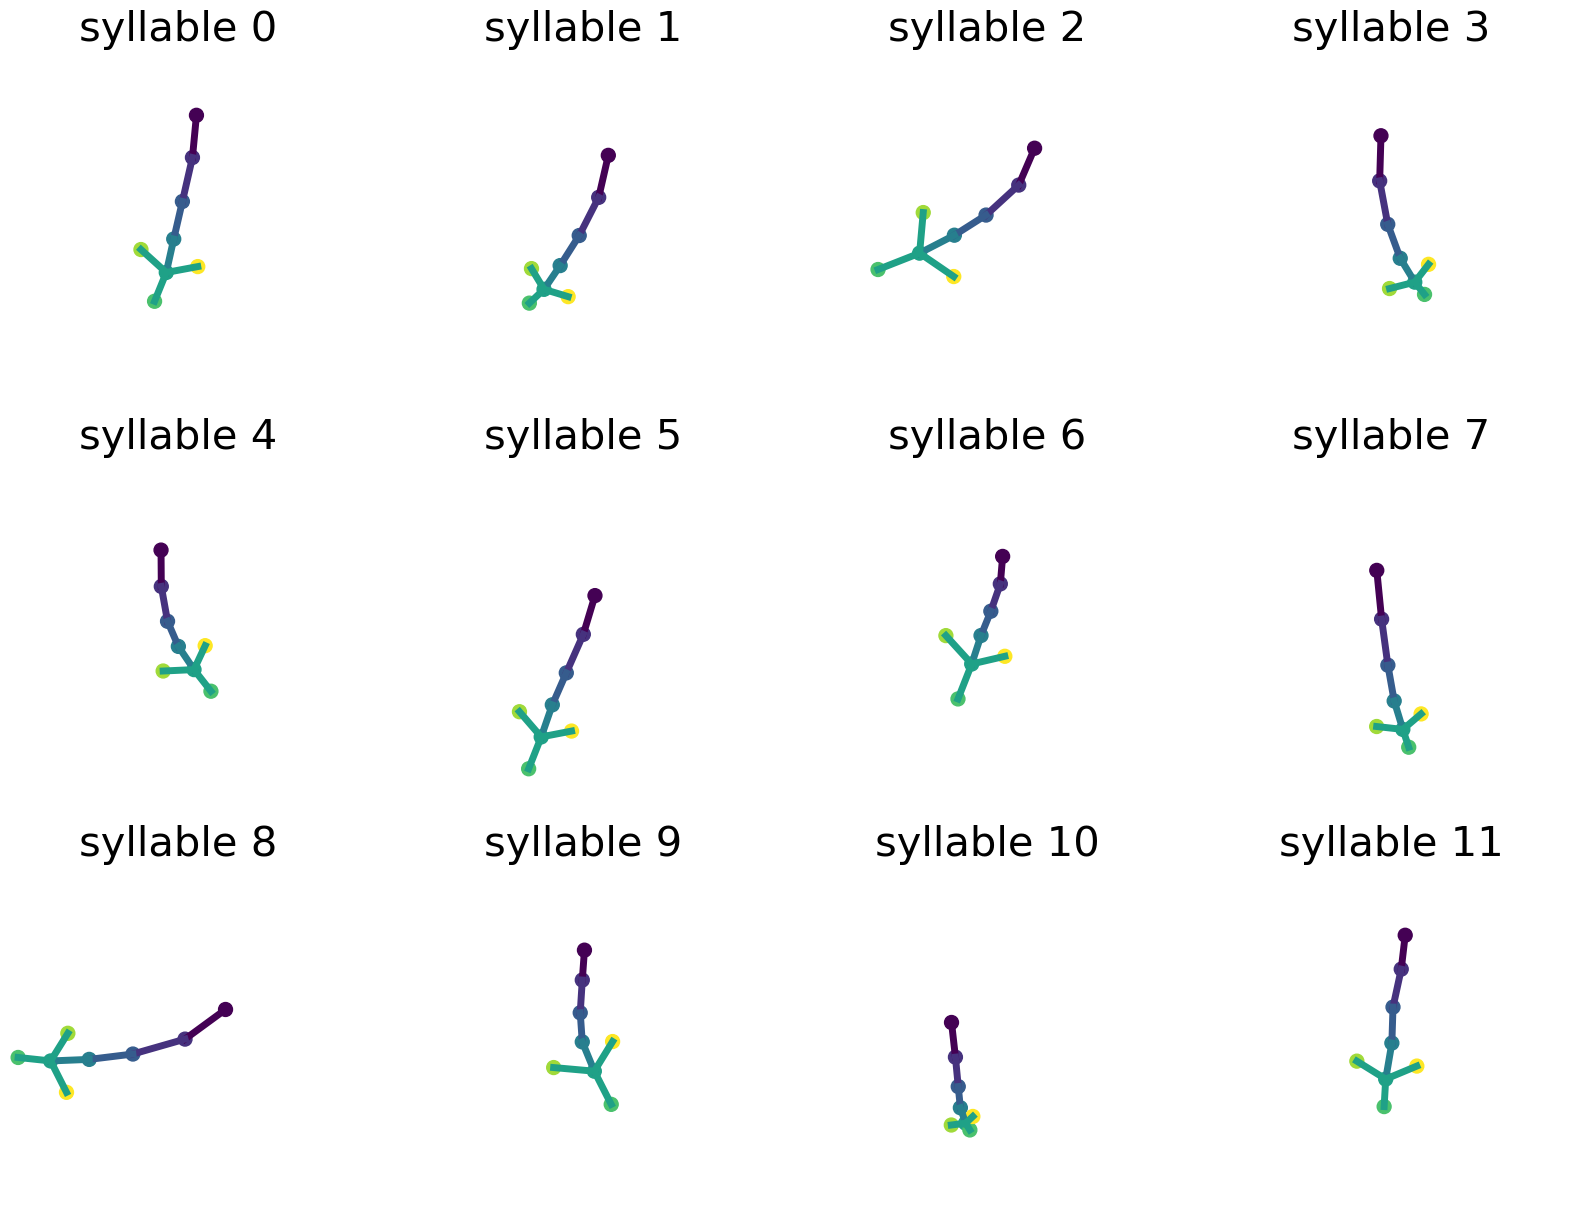

In [8]:
from sklearn.linear_model import LinearRegression
from visualize import plot_gif_all_syllables
train_buffer_path = './kms/train_data_all.pth'
train_buffer_state_dict = torch.load(train_buffer_path)
state_dim, action_dim = 16, 16
train_buffer = buffer.ReplayBuffer(state_dim, action_dim, max_size=10000)
train_buffer.load_state_dict(train_buffer_state_dict)
test_buffer_path = './kms/test_data_all.pth'
replay_buffer_state_dict = torch.load(test_buffer_path)
state_dim, action_dim = 16, 16
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, max_size=10000)
test_buffer.load_state_dict(replay_buffer_state_dict)
timestep = 30
state_dim = action_dim = 16
n_syllable = 78
state_seqs = np.zeros((n_syllable, timestep, state_dim))
coef_matrix, intercept_matrix = np.zeros((n_syllable, state_dim, action_dim)), np.zeros((n_syllable, action_dim))
var_matrix = np.ones((n_syllable, action_dim))
covar_matrix = np.zeros((n_syllable, action_dim, action_dim))
covar_matrix_inv = np.zeros((n_syllable, action_dim, action_dim))
logdet_matrix = np.zeros((n_syllable, 1))
for syllable in range(n_syllable):
    print('syllable:', syllable)
    lr = LinearRegression()
    idx = np.where(train_buffer.task == syllable)[0]
    # state, action, next_state, reward, done, task, next_task = unpack_batch(train_buffer.take(idx))
    state = train_buffer.state[idx]
    action = train_buffer.action[idx]
    if state.shape[0] == 0:
        continue
    lr.fit(state, action)
    coef_matrix[syllable] = lr.coef_
    intercept_matrix[syllable] = lr.intercept_
    err = action - lr.predict(state)
    covar_matrix[syllable] = err.T @ err / err.shape[0]
    # print(covar_matrix[syllable])
    tol = 1e-8
    covar_matrix_inv[syllable] = np.linalg.pinv(covar_matrix[syllable], rcond=tol)
    s = np.linalg.svd(covar_matrix[syllable], compute_uv=False)
    s_filter = s[s > tol]
    logdet_matrix[syllable] = np.sum(np.log(s_filter))
    print('det:', logdet_matrix[syllable])
    var_matrix[syllable] = np.var(action - lr.predict(state), axis=0, ddof=action_dim+1)
    # new_action_pred = lr.predict(state)
    # error = np.abs(new_next_state_pred - next_state)
    # print(error.shape)
    # error_mean = np.mean(error, axis=0)
    # print(error_mean, error_mean.mean())
    # all_error[syllable] = check_multiple_step_rollout(lr, syllable, replay_buffer)
    # print(syllable, all_error[syllable])
    sample_idx = 90
    state = test_buffer.state[sample_idx]
    state_seqs[syllable, 0] = state
    for i in range(1, timestep):
        action = lr.predict(state.reshape(1, -1))
        # print('action:', action.shape)
        next_state = action + state
        state_seqs[syllable, i] = next_state
        state = next_state
plot_gif_all_syllables(state_seqs, f'./figure/kms/linear_state_pred90/task.gif')
pickle.dump({'coef_matrix': coef_matrix, 'intercept_matrix': intercept_matrix, 'var_matrix': var_matrix,
             'covar_matrix': covar_matrix, 'covar_matrix_inv': covar_matrix_inv, 'logdet_matrix': logdet_matrix},
            open('./kms/linear_all.pkl', 'wb'))
print('./kms/linear_all.pkl')


Fit a linear model for each syllable

In [ ]:
from sklearn.linear_model import LinearRegression
from visualize import plot_gif
from visualize import plot_gif_all_syllables
from utils.util import unpack_batch
train_buffer_path = './kms/train_data_all.pth'
train_buffer_state_dict = torch.load(train_buffer_path)
state_dim, action_dim = 16, 16
train_buffer = buffer.ReplayBuffer(state_dim, action_dim, max_size=10000)
train_buffer.load_state_dict(train_buffer_state_dict)
test_buffer_path = './kms/test_data_all.pth'
replay_buffer_state_dict = torch.load(test_buffer_path)
state_dim, action_dim = 16, 16
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, max_size=10000)
test_buffer.load_state_dict(replay_buffer_state_dict)
timestep = 30
state_dim = action_dim = 16
n_syllable = 78
state_seqs = np.zeros((n_syllable, timestep, state_dim))
# all_error = np.zeros((10,))
batch_size = 512
for syllable in range(n_syllable):
    print('syllable:', syllable)
    lr = LinearRegression()
    # state_set = []
    # action_set = []
    # for j in range(10):
    #     batch = train_buffer.sample(batch_size)
    #     state, action, next_state, reward, _, task, next_task = unpack_batch(batch)
    #     all_idx = np.where(task.cpu().numpy() == syllable)[0]
    #     state_set.append(state[all_idx].cpu().numpy())
    #     action_set.append(action[all_idx].cpu().numpy())
    # state_set = np.concatenate(state_set, axis=0)
    # action_set = np.concatenate(action_set, axis=0)
    # lr.fit(state_set, action_set)

    # new_action_pred = lr.predict(state)
    # error = np.abs(new_next_state_pred - next_state)
    # print(error.shape)
    # error_mean = np.mean(error, axis=0)
    # print(error_mean, error_mean.mean())
    # all_error[syllable] = check_multiple_step_rollout(lr, syllable, replay_buffer)
    # print(syllable, all_error[syllable])
    sample_idx = 90
    state = test_buffer.state[sample_idx]
    state_seqs[syllable, 0] = state
    for i in range(1, timestep):
        action = lr.predict(state.reshape(1, -1))
        # print('action:', action.shape)
        next_state = action + state
        state_seqs[syllable, i] = next_state
        state = next_state
plot_gif_all_syllables(state_seqs, f'./figure/kms/linear_state_pred90/task.gif')
# plot_gif(state_seqs, f'./figure/kms/linear_state_pred90/{syllable}task.gif')
# print(state_seqs[0].shape)
    # np.save(f'./kms/s_mean.npy', state_seqs[0].reshape(-1,2))
# print('all:', all_error.mean())

Load replay buffer and normalize it

In [2]:
state_dim = 16
action_dim = 16
n_task = 78
test_buffer_path = './kms/replay_buffer_all.pth'
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
test_buffer.load_state_dict(torch.load(test_buffer_path))

In [ ]:
linear_model = torch.load('./kms/linear_model_discrete.pth')
linear_model.predict(test_buffer.state[:5])

In [3]:
scale_factor = 200
action_all = test_buffer.action
print(action_all.shape[0])
# syllable_indicator = (replay_buffer.task == 3).squeeze()
# print(len(np.where(all_idx)[0]))
filtered_replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
size = test_buffer.size
# filtered_replay_buffer.state = replay_buffer.state
# filtered_replay_buffer.next_state = replay_buffer.next_state
# assert np.isclose(replay_buffer.state + replay_buffer.action, replay_buffer.next_state).all()
new_state = test_buffer.state
new_next_state = test_buffer.next_state

state_mean = np.mean(np.concatenate([new_state, new_next_state[-2:]], axis=0))
print(state_mean)
mildnormalized_state = (new_state - state_mean) / scale_factor
filtered_replay_buffer.state = mildnormalized_state

mildnormalized_next_state = (new_next_state - state_mean) / scale_factor
filtered_replay_buffer.next_state = mildnormalized_next_state

new_action = test_buffer.action
filtered_replay_buffer.action = new_action/scale_factor
# mildnormalized_action = new_action / scale_factor
# filtered_replay_buffer.action = mildnormalized_action

filtered_replay_buffer.reward = test_buffer.reward
filtered_replay_buffer.done = test_buffer.done
filtered_replay_buffer.task = test_buffer.task
filtered_replay_buffer.next_task = test_buffer.next_task
filtered_replay_buffer.size = test_buffer.size
filtered_replay_buffer.ptr = 0

# assert np.isclose(filtered_replay_buffer.state + filtered_replay_buffer.action, filtered_replay_buffer.next_state).all()
torch.save(filtered_replay_buffer.state_dict(), './kms/replay_buffer_all_normalized.pth')

643901
302.52627666744837


Load from the whole dataset and split it into trainset and testset

In [2]:
state_dim = 16
action_dim = 16
n_task = 10
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
test_buffer.load_state_dict(torch.load('./kms/replay_buffer_all_normalized.pth'))
print(np.unique(test_buffer.action))
# action_onehot = np.eye(5)[replay_buffer.action.astype(int)]
assert np.isclose(test_buffer.state + test_buffer.action, test_buffer.next_state).all()
# print(action_onehot.shape)
# replay_buffer.action = action_onehot.reshape(action_onehot.shape[0], -1)
# replay_buffer.action = replay_buffer.action.astype(int)

[-1.37 -1.31 -1.3  -1.23 -1.22 -1.14 -1.13 -1.12 -1.11 -1.1  -1.09 -1.08
 -1.07 -1.06 -1.05 -1.04 -1.03 -1.02 -1.01 -1.   -0.99 -0.98 -0.97 -0.96
 -0.95 -0.94 -0.93 -0.92 -0.91 -0.9  -0.89 -0.88 -0.87 -0.86 -0.85 -0.84
 -0.83 -0.82 -0.81 -0.8  -0.79 -0.78 -0.76 -0.75 -0.74 -0.73 -0.71 -0.7
 -0.69 -0.68 -0.66 -0.65 -0.64 -0.63 -0.62 -0.61 -0.6  -0.59 -0.58 -0.57
 -0.56 -0.55 -0.54 -0.53 -0.52 -0.51 -0.5  -0.49 -0.48 -0.47 -0.46 -0.45
 -0.44 -0.43 -0.42 -0.41 -0.4  -0.39 -0.38 -0.37 -0.36 -0.35 -0.34 -0.33
 -0.32 -0.31 -0.3  -0.29 -0.28 -0.27 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21
 -0.2  -0.19 -0.18 -0.17 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09
 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01  0.    0.01  0.02  0.03
  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11  0.12  0.13  0.14  0.15
  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23  0.24  0.25  0.26  0.27
  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35  0.36  0.37  0.38  0.39
  0.4   0.41  0.42  0.43  0.44  0.45  0.47  0.48  0.

In [3]:
idx = np.arange(test_buffer.size)
# np.random.shuffle(idx)
train_idx = idx[:int(test_buffer.size * 0.8)]
test_idx = idx[int(test_buffer.size * 0.8):]
train_data = {}
test_data = {}
key = ['state', 'action', 'next_state', 'reward', 'done', 'task', 'next_task']
for k in key:
    train_data[k] = test_buffer.__getattribute__(k)[train_idx]
    test_data[k] = test_buffer.__getattribute__(k)[test_idx]
train_data['size'] = len(train_idx)
test_data['size'] = len(test_idx)
train_data['ptr'] = 0
test_data['ptr'] = 0
# np.savez('./kms/train_data_sequential_discrete_action04.npz', **train_data)
# np.savez('./kms/test_data_sequential_discrete_action04.npz', **test_data)
torch.save(train_data, './kms/train_data_all.pth')
torch.save(test_data, './kms/test_data_all.pth')
print(len(train_idx), len(test_idx))
print(np.unique(train_data['action'], return_counts=True))
print(np.unique(test_data['action'], return_counts=True))
print(np.unique(train_data['done'], return_counts=True))
print(np.unique(test_data['done'], return_counts=True))

515120 128781
(array([-1.23, -1.22, -1.14, -1.13, -1.12, -1.11, -1.1 , -1.09, -1.08,
       -1.07, -1.06, -1.05, -1.04, -1.03, -1.02, -1.01, -1.  , -0.99,
       -0.98, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92, -0.91, -0.9 ,
       -0.89, -0.88, -0.87, -0.86, -0.85, -0.84, -0.83, -0.82, -0.81,
       -0.8 , -0.79, -0.78, -0.76, -0.75, -0.74, -0.73, -0.71, -0.7 ,
       -0.69, -0.68, -0.66, -0.65, -0.64, -0.63, -0.62, -0.61, -0.6 ,
       -0.59, -0.58, -0.57, -0.56, -0.55, -0.54, -0.53, -0.52, -0.51,
       -0.49, -0.48, -0.47, -0.46, -0.45, -0.44, -0.43, -0.42, -0.41,
       -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33, -0.32,
       -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23,
       -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14,
       -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05,
       -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,
        0.05,  0.06,  0.07,  0.08,  0.09,  0.1 ,  0.11,  0.12,  0.13,
     

In [ ]:
3795722/(94596+784483+3795722+823329+101838)

Load from raw data and creates dataset

In [2]:
dlc_sample = pickle.load(open('./kms/dlc_sample.pkl', 'rb'))
print(dlc_sample.keys())
print(dlc_sample['coordinates'].keys())
print(dlc_sample['coordinates']['22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000'].shape)

dict_keys(['coordinates', 'bodyparts'])
dict_keys(['22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_2_def6b_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_10_def6a_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '22_04_26_cage4_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_2_def6a_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_10_def6b_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '22_04_26_cage4_0_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_11_8_one_mouse.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '22_27_04_cage4_mouse2_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000'])
(53623, 9, 2)


In [3]:
results = h5py.File('./kms/results.h5', 'r')
print(np.array(results['22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000']['syllable']))

[14 14 14 ...  3  3  3]


In [4]:
syllables = {k:v['syllable'] for k,v in results.items()}
print(syllables)

{'21_11_8_one_mouse.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (71524,), type "<i8">, '21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (53512,), type "<i8">, '21_12_10_def6a_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (35818,), type "<i8">, '21_12_10_def6b_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (53527,), type "<i8">, '21_12_2_def6a_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (107507,), type "<i8">, '21_12_2_def6b_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (107520,), type "<i8">, '22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (53623,), type "<i8">, '22_04_26_cage4_0_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable":

This proves that the states are sorted by instance frequency

In [5]:
# stateseqs = {
#         'name1': np.array([1, 1, 2, 2, 2, 3]),
#         'name2': np.array([0, 0, 0, 1])}
stateseq_flat = np.hstack(list(syllables.values()))
state_onsets = np.pad(np.diff(stateseq_flat).nonzero()[0] + 1, (1, 0))
stateseq_flat = stateseq_flat[state_onsets]
counts = np.bincount(stateseq_flat, minlength=77)
print(counts[:25])
print(np.all(np.diff(counts)<=0))


[6135 3715 3226 3165 2824 2584 2295 2043 1845  853  681  500  458  420
  329  328  294  212  204  181  134  122  117   82   72]
True


In [6]:
def rotate(state, action, next_state, reward, done, task, next_task):
    theta = np.random.uniform(0, 2*np.pi)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    assert state.shape == (16, )
    assert action.shape == (16, )
    assert next_state.shape == (16, )
    assert np.isclose(state + action, next_state).all()
    new_state = (state.reshape(-1,2) @ rotation_matrix).reshape(-1)
    new_next_state = (next_state.reshape(-1,2) @ rotation_matrix).reshape(-1)
    new_action = (action.reshape(-1,2) @ rotation_matrix).reshape(-1)
    assert np.isclose(new_state + new_action, new_next_state).all()
    return new_state, new_action, new_next_state, reward, done, task, next_task
def shift(state, action, next_state, reward, done, task, next_task):
    shift = np.random.randn(2)
    # print('shift:', shift)
    assert state.shape == (16, )
    assert action.shape == (16, )
    assert next_state.shape == (16, )
    assert np.isclose(state + action, next_state).all()
    new_state = (state.reshape(-1,2) + shift).reshape(-1)
    new_next_state = (next_state.reshape(-1,2) + shift).reshape(-1)
    new_action = action
    # print('state:', state, new_state)
    # print('action:', action, new_action)
    # print('next_state:', next_state, new_next_state)
    # print('compare:', new_state + new_action, new_next_state)
    assert np.isclose(new_state + new_action, new_next_state).all()
    return new_state, new_action, new_next_state, reward, done, task, next_task
    

In [7]:
bodyparts=[
    'tail', 'spine4', 'spine3', 'spine2', 'spine1',
    'head', 'nose', 'right ear', 'left ear']
use_bodyparts=[
        'spine4', 'spine3', 'spine2', 'spine1',
        'head', 'nose', 'right ear', 'left ear']
use_bodyparts_idx = [bodyparts.index(bp) for bp in use_bodyparts]
state_dim = len(use_bodyparts) * 2
action_dim = len(use_bodyparts) * 2
n_task = 10 # filter out some non-frsequent tasks
extra_augmentation_step = 1
original_replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 1000000, 'cpu')
for name in dlc_sample['coordinates'].keys():
    print(name)
    for i in range(len(dlc_sample['coordinates'][name])-1):
        state = np.array(dlc_sample['coordinates'][name][i][use_bodyparts_idx].flatten())
        next_state = np.array(dlc_sample['coordinates'][name][i+1][use_bodyparts_idx].flatten())
        action = next_state - state
        task = np.array(results[name]['syllable'][i])
        next_task = np.array(results[name]['syllable'][i+1])
        ###这个done是否和transition_point相吻合？
        done = np.where(next_task != task, 1, 0)
        assert not np.all(np.isnan(state))
        # if task < n_task and next_task < n_task:
        original_replay_buffer.add(state, action, next_state, 0, done, task, next_task)
            # for j in range(extra_augmentation_step):
            #     an_item = shift(*rotate(state, action, next_state, 0, 0, task, next_task))
            #     assert np.isclose(an_item[0] + an_item[1], an_item[2]).all()
            #     original_replay_buffer.add(*an_item)
print(original_replay_buffer.size)



22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_12_2_def6b_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_12_10_def6a_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
22_04_26_cage4_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_12_2_def6a_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_12_10_def6b_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
22_04_26_cage4_0_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_11_8_one_mouse.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
22_27_04_cage4_mouse2_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
643901


In [8]:
print(np.unique(original_replay_buffer.task, return_counts=True))
torch.save(original_replay_buffer.state_dict(), './kms/replay_buffer_all.pth')

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.]), array([487207,  59812,  42725,  47387,  39871,  48782,  51433,  23759,
        24973,  18731,  16190,   9936,  10839,  14886,  13244,  20201,
         9627,   2072,   2720,  10088,    344,   4630,   2116,   5316,
        12381,   2465,   3131,    709,   2452,    279,   1558,   1389,
         3583,    204,    190,     37,   1031,    486,    112,     26,
           21,     14,    305,     47,    344,    124,    874,     73,
           63,    179,    250,    104,     10,     18,     20,     41,
           50,     42,     20,    106,     13,     10,     23,     1

In [ ]:
length = original_replay_buffer.size
print(original_replay_buffer.state[:10000])

This normalization scales every dimension with the same factor to make sure that the relative position is not discarded

In [ ]:
# normalize
all_state = original_replay_buffer.state[:length]
all_next_state = original_replay_buffer.next_state[:length]
state_min = np.concatenate([all_state, all_next_state[-1:]]).min()
state_max = np.concatenate([all_state, all_next_state[-1:]]).max()
state_range = state_max - state_min
normalized_state = (all_state - state_min) / state_range * 2 - 1
normalized_next_state = (all_next_state - state_min) / state_range * 2 - 1
# print(normalized_next_state.min(0), normalized_next_state.max(0))
all_action = original_replay_buffer.action[:length]
action_min = all_action.min()
action_max = all_action.max()
action_range = action_max - action_min
normalized_action = (all_action - action_min) / action_range * 2 - 1
# for i in range(state_dim):
#     print(all_action[:100,i])
#     plt.hist(all_action[:, i], bins=100)
#     plt.show()
for i in range(200):
    print(all_action[i].max(), end=' ')
####ACTION

In [ ]:
shuffle_idx = np.arange(length)
np.random.shuffle(shuffle_idx)
train_idx = shuffle_idx[:int(length*0.8)]
test_idx = shuffle_idx[int(length*0.8):]
train_state = torch.FloatTensor(normalized_state[train_idx])
train_action = torch.FloatTensor(normalized_action[train_idx])
train_next_state = torch.FloatTensor(normalized_next_state[train_idx])
train_task = torch.Tensor(original_replay_buffer.task[train_idx])
train_next_task = torch.Tensor(original_replay_buffer.next_task[train_idx])
train_reward = torch.zeros((train_state.shape[0], 1))
train_done = torch.zeros((train_state.shape[0], 1))
train_buffer_state_dict = {'state': train_state, 
                           'action': train_action, 
                           'next_state': train_next_state, 
                           'reward': train_reward, 
                           'done': train_done, 
                           'task': train_task, 
                           'next_task': train_next_task,
                           'size': len(train_idx),
                           'ptr': 0}
test_state = torch.FloatTensor(normalized_state[test_idx])
test_action = torch.FloatTensor(normalized_action[test_idx])
test_next_state = torch.FloatTensor(normalized_next_state[test_idx])
test_task = torch.Tensor(original_replay_buffer.task[test_idx])
test_next_task = torch.Tensor(original_replay_buffer.next_task[test_idx])
test_reward = torch.zeros((test_state.shape[0], 1))
test_done = torch.zeros((test_state.shape[0], 1))
test_buffer_state_dict = {'state': test_state, 
                          'action': test_action, 
                          'next_state': test_next_state, 
                          'reward': test_reward, 
                          'done': test_done, 
                          'task': test_task, 
                          'next_task': test_next_task,
                          'size': len(test_idx),
                          'ptr': 0}



In [ ]:
torch.save(train_buffer_state_dict, './kms/train_buffer_state_dict.pth')
torch.save(test_buffer_state_dict, './kms/test_buffer_state_dict.pth')
print(train_state.shape, test_state.shape)

In [ ]:
normalize_dict = {
    'state_min': state_min,
    'state_max': state_max,
    'action_min': action_min,
    'action_max': action_max
}
torch.save(normalize_dict, './kms/normalize_dict.pth')

In [ ]:
task_all = original_replay_buffer.task
freq = np.zeros((int(task_all.max()), ))
print(len(freq))
for i in range(len(freq)):
    freq[i] = len(task_all[task_all == i])
print(np.argsort(freq))

In [ ]:
state_dim = 54
action_dim = 54
n_task = 60
original_replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 100000, 'cuda:0')
test_buffer_path = f'./data/replay_buffer_18body_normalized_new.pth'
original_replay_buffer.load_state_dict(torch.load(test_buffer_path))

state_all, action_all, next_state_all, task_all, next_task_all, reward_all, done_all = \
    original_replay_buffer.state, original_replay_buffer.action, original_replay_buffer.next_state, original_replay_buffer.task,\
    original_replay_buffer.next_task, original_replay_buffer.reward, original_replay_buffer.done

length = original_replay_buffer.size
print(length)
syllable_idx = np.arange(length)
np.random.shuffle(syllable_idx)
train_idx = torch.tensor(syllable_idx[:int(0.8*length)])
test_idx = torch.tensor(syllable_idx[int(0.8*length):])
print(len(train_idx), len(test_idx))
train_buffer = buffer.ReplayBuffer(state_dim, action_dim, 100000, 'cuda:0')
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 100000, 'cuda:0')
for key in original_replay_buffer.state_dict().keys():
    if key != 'ptr' and key != 'size':
        print(key)
        train_buffer.__setattr__(key, original_replay_buffer.__getattribute__(key)[train_idx])
        test_buffer.__setattr__(key, original_replay_buffer.__getattribute__(key)[test_idx])
train_buffer.size = len(train_idx)
test_buffer.size = len(test_idx)
print(train_buffer.size, test_buffer.size)
train_buffer_path = './data/replay_buffer_18body_normalized_new_train.pth'
test_buffer_path = './data/replay_buffer_18body_normalized_new_test.pth'
torch.save(train_buffer.state_dict(), train_buffer_path)
torch.save(test_buffer.state_dict(), test_buffer_path)
print('Save')

In [ ]:
def load_rat7m():
    state_dim = 8
    action_dim = 8
    replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 1000000)
    replay_buffer_path = f'../../rat7m/replay_buffer_3sigma_tanh.pth'
    replay_buffer.load_state_dict(torch.load(replay_buffer_path))
    print(f'Replay buffer loaded from {replay_buffer_path}')
    return replay_buffer, state_dim, action_dim
original_replay_buffer, state_dim, action_dim = load_rat7m()
print(original_replay_buffer.state[:5], original_replay_buffer.action[:5])

In [ ]:
matrix_notxyz = np.load('./figure/rat7m/spedersac/dim64_sa_sp_buffer_20body_normalized_lasso_1e-2/0/ig_matrix_agg.npy')
matrix_xyz = np.load('./figure/rat7m/spedersac/dim64_sa_sp_buffer_20body_normalzied_lasso1e-2_xyz_group/0/ig_matrix_agg.npy')
corr = np.corrcoef(matrix_notxyz.flatten(), matrix_xyz.flatten())[0, 1]
print(corr)

In [ ]:
import torch

phi_hidden_dim = 10
input_dim = 9  # suppose we have 2 groups, each with xyz => 2*3=6
W = torch.randn(phi_hidden_dim, input_dim)

# Original approach
W_orig = W.reshape(phi_hidden_dim, input_dim//3, 3)
orig_lasso = torch.sqrt(W_orig.pow(2).sum(dim=0).sum(dim=-1)).sum()

# New approach
W_t = W.T.reshape(-1, phi_hidden_dim*3)
new_lasso = torch.norm(W_t, dim=1).sum()

print("orig_lasso =", orig_lasso.item())
print("new_lasso  =", new_lasso.item())

In [ ]:
state_name = ['HeadF','HeadB','HeadL','SpineF','SpineM',
                'SpineL','HipL','HipR','ElbowL','ArmL',
                'ShoulderL','ShoulderR','ElbowR','ArmR','KneeR',
                'KneeL','ShinL','ShinR']
# When I transfer the skeleton into edges, Please refer to the following skeleton.

state_name = ['HeadF','HeadB','HeadL','SpineF','SpineM',
              'SpineL','HipL','HipR','ElbowL','ArmL',
              'ShoulderL','ShoulderR','ElbowR','ArmR','KneeR',
              'KneeL','ShinL','ShinR']

skeleton = [('HeadF', 'HeadB'), ('HeadF', 'HeadL'), ('HeadB', 'HeadL'),
            ('HeadB', 'SpineF'), ('HeadL', 'SpineF'), ('SpineF', 'SpineM'),
            ('SpineM', 'SpineL'), ('SpineF', 'ShoulderL'), ('ShoulderL', 'ElbowL'),
            ('ElbowL', 'ArmL'), ('SpineF', 'ShoulderR'), ('ShoulderR', 'ElbowR'),
            ('ElbowR', 'ArmR'), ('SpineM', 'HipL'), ('HipL', 'KneeL'),
            ('KneeL', 'ShinL'), ('SpineM', 'HipR'), ('HipR', 'KneeR'),
            ('KneeR', 'ShinR')]
edges = []
for i in skeleton:
  edges.append((state_name.index(i[0]), state_name.index(i[1])))

import joblib
import numpy as np
import matplotlib.pyplot as plt
pca = joblib.load('./pca.p')
print(pca)

In [ ]:
def center_embedding(n):
    """
    Generates a matrix ``Gamma`` that maps from a (n-1)-dimensional
    vector space  to the space of k-tuples with zero mean

    Parameters
    ----------
    n : int
        Number of keypoints.

    Returns
    -------
    Gamma: jax array of shape (n, n - 1)
        Matrix to map to centered embedded space.
    """
    X = np.tril(np.ones((n, n)), k=-1)[1:]
    X = np.eye(n)[1:] - X / X.sum(1)[:, None]
    X = X / np.sqrt((X**2).sum(1))[:, None]
    return X.T
Gamma = np.array(center_embedding(len(state_name)))

ymean = Gamma @ pca.mean_.reshape(len(state_name)-1, -1)
ymean[state_name.index('HeadB'), 2] -= 10
ymean[state_name.index('HeadF'), 0] += 10
ymean[state_name.index('SpineL'), 2] += 20
ymean[state_name.index('ShoulderL'), 0] += 20
ymean[state_name.index('ElbowL'), 0] += 20
ymean[state_name.index('ElbowL'), 2] += 10
ymean[state_name.index('ArmL'), 0] += 30
ymean[state_name.index('ArmL'), 2] += 10
ymean[state_name.index('ArmR'), 0] += 10
ymean[state_name.index('HipL'), 2] += 10
ymean[state_name.index('HipL'), 0] += 30
ymean[state_name.index('KneeL'), 2] += 10
ymean[state_name.index('KneeL'), 0] += 30
ymean[state_name.index('ShinL'), 2] += 10
ymean[state_name.index('ShinL'), 0] += 30
ymean[state_name.index('HipR'), 0] -= 10
ymean[state_name.index('HipR'), 2] += 10
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
dims = [0, 2]
dims, name = [0,2], 'xz'
cmap = plt.cm.get_cmap('viridis')
keypoint_colors = cmap(np.linspace(0, 1, len(state_name)))
# print(keypoint_colors)
n_bodyparts = len(state_name)
ig_matrix_agg_xyz = np.load('./figure/rat7m/spedersac/dim64_sa_sp_buffer_20body_normalzied_lasso1e-2_xyz_group/0/ig_matrix_agg.npy')
for e in edges:
    axes.plot(
        *ymean[:, dims][e,:].T,
        color=keypoint_colors[e[0]],
        linewidth=5.0,
        zorder=0)
node_colors = ['blue' if ig_matrix_agg_xyz[0, j] < 0 else 'red' for j in range(2*n_bodyparts)]
axes.scatter(
        *ymean[:, dims].T,
        c=node_colors[:n_bodyparts],
        s=np.abs(ig_matrix_agg_xyz[0, :n_bodyparts])*120,
        zorder=1)
axes.axis('off')
plt.show()

In [ ]:
np.save('ymean.npy', ymean)